## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from statistics import mean, median


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

## Load result data

In [3]:
import json 

with open("experiment_rcs_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [4]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'varying_qubits', 'varying_redundancy', 'varying_gates'}


In [5]:
seeds = [experiment["params"]["seed"] for experiment in experiments]
seeds = list(set(seeds))

print(seeds)

[0, 1, 2, 3, 4]


In [6]:
target_dir = "results_rcs" # Used for storing plots

## RQ1: How does the degree of redundancy within a population influence the behavior of the proposed simulation approach?

In [7]:
# Filter out and format experiment results with the varying_redundancy tag

vr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_redundancy"]
print(f"Total amount of varying_redundancy experiments: {len(vr_experiments)}")

Total amount of varying_redundancy experiments: 80


In [8]:
redundancies = [experiment["params"]["redundancy"] for experiment in vr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


Total simulation time, averaged across seeds:


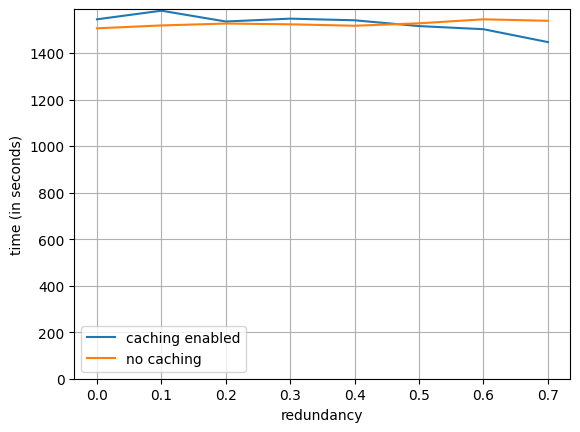

In [9]:
# Create a line chart with simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache, label="caching enabled")
ax.plot(redundancies, durations_no_cache, label="no caching")
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_redundancy.png")
plt.show()

Net simulation time, averaged across seeds:


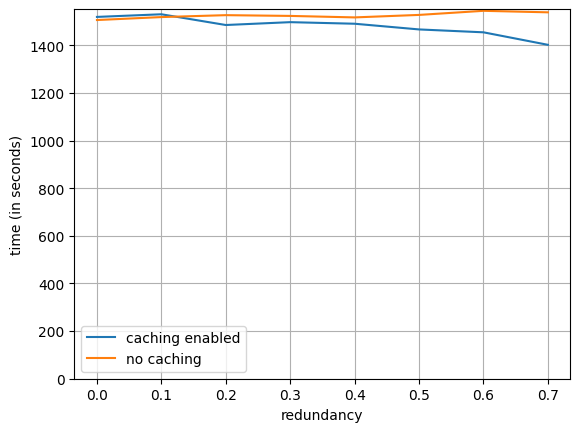

In [10]:
# Create a line chart with net simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["simulate_without_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache, label="caching enabled")
ax.plot(redundancies, durations_no_cache, label="no caching")
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/net_time_over_redundancy.png")
plt.show()

Total simulation time with caching disabled:


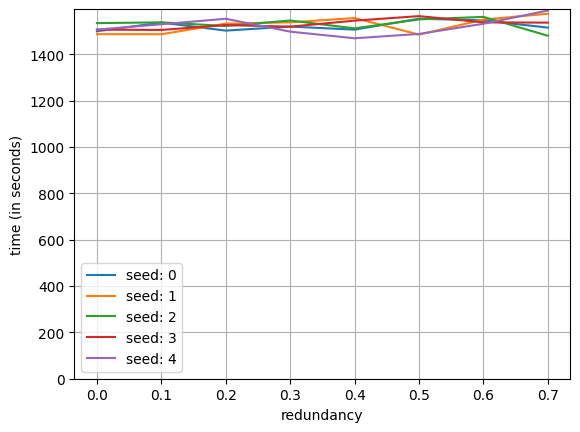

In [11]:
# plot simulation time of each seed without cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_no_cache = []

    for redundancy in redundancies:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_no_cache.append(sel_durations_no_cache[0])

    ax.plot(redundancies, seed_durations_no_cache, label=f"seed: {seed}")

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Total simulation time with caching disabled:")
plt.legend()
plt.grid()
plt.show()

Total simulation time with caching enabled:


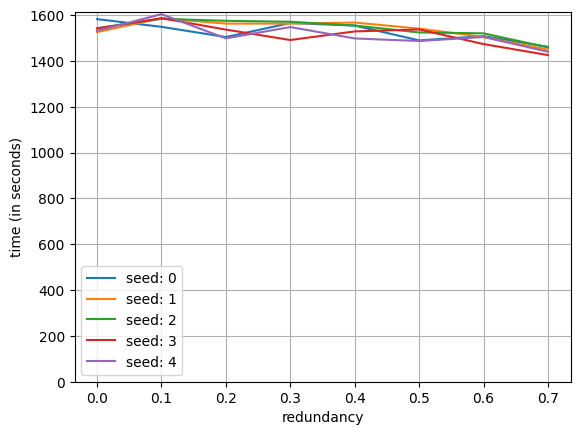

In [12]:
# plot simulation time of each seed with cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_with_cache = []

    for redundancy in redundancies:

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_with_cache.append(sel_durations_with_cache[0])

    ax.plot(redundancies, seed_durations_with_cache, label=f"seed: {seed}")

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time with caching enabled:")
plt.legend()
plt.grid()
plt.show()

Cache buildup and net simulation time, averaged across seeds:


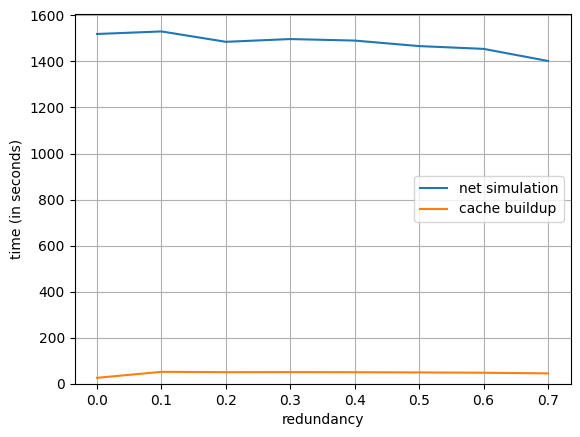

In [13]:
# Create a line chart with simulation vs. preparation time of 
# caching enabled.
simulation_durations = []
overhead_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_simulation_durations = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]
    sel_overhead_durations = [
        experiment["total_duration"] - experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]

    simulation_durations.append(mean(sel_simulation_durations))
    overhead_durations.append(mean(sel_overhead_durations))


ax = plt.subplot()
ax.plot(redundancies, simulation_durations, label="net simulation")
ax.plot(redundancies, overhead_durations, label="cache buildup")
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Cache buildup and net simulation time, averaged across seeds:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/net_time_vs_cache_buildup.png")
plt.show()

Trie lookup duration, averaged across seeds:


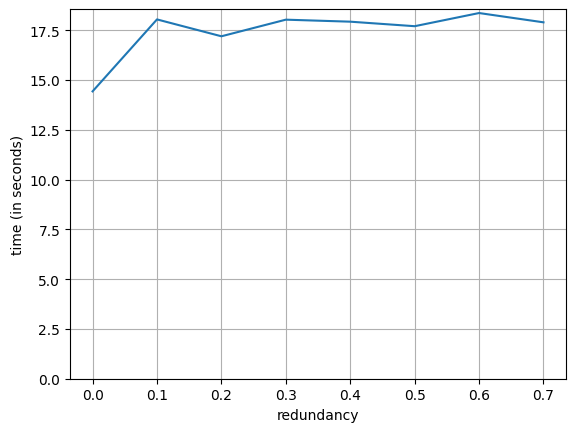

In [14]:
# Plot trie lookup durations averaged across seeds

trie_lookup_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_trie_lookup_durations = [
        experiment["simulate_using_cache"]["trie_lookup_duration"]
        for experiment in relevant_experiments
    ]

    trie_lookup_durations.append(mean(sel_trie_lookup_durations))


ax = plt.subplot()
ax.plot(redundancies, trie_lookup_durations)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Trie lookup duration, averaged across seeds:")
plt.grid()
plt.show()

Net simulation duration without trie lookup, averaged across seeds:


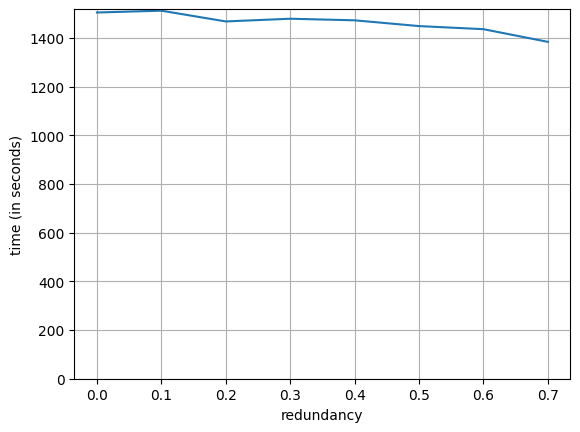

In [15]:
# Create a line chart with simulation vs. preparation time of 
# caching enabled.

simulation_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_simulation_durations = [
        experiment["simulate_using_cache"]["duration"] - experiment["simulate_using_cache"]["trie_lookup_duration"]
        for experiment in relevant_experiments
    ]

    simulation_durations.append(mean(sel_simulation_durations))


ax = plt.subplot()
ax.plot(redundancies, simulation_durations)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation duration without trie lookup, averaged across seeds:")
plt.grid()
plt.show()

Time distribution when caching is enabled:


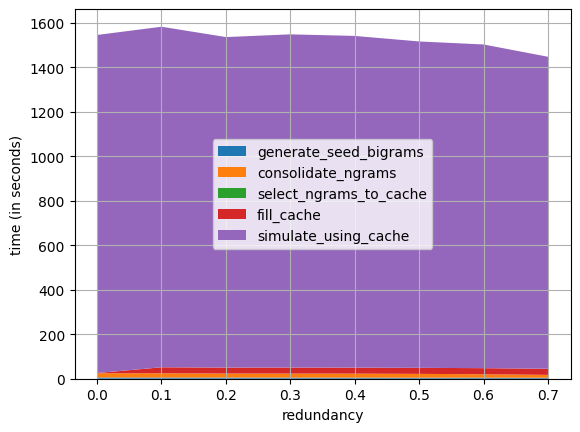

In [16]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )

x = redundancies
y = np.vstack(
    [
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")

plt.legend(
    [
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

printb("Time distribution when caching is enabled:")
plt.savefig(f"{target_dir}/time_over_redundancy_stacked.png")
plt.show()

Distribution of the length of ngrams added to the cache:


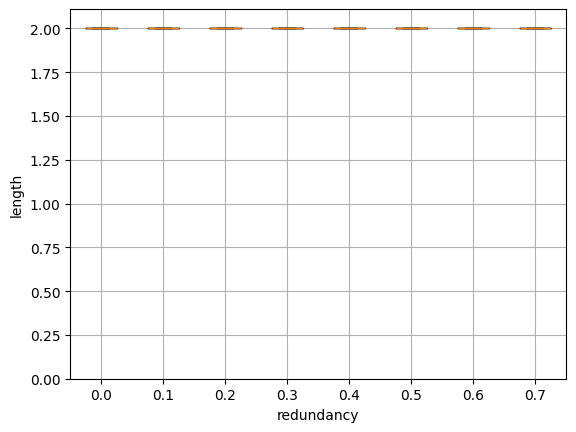

In [17]:
# Create box plots for sequence lengths of cached ngrams
# at different redundancy levels.

sequence_lengths = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_sequence_lengths = []
    for experiment in relevant_experiments:
        relevant_sequence_lengths.extend(experiment["fill_cache"]["ngram_lengths"])


    sequence_lengths.append(relevant_sequence_lengths)

fig, ax = plt.subplots()

ax.boxplot(sequence_lengths, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("length")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the length of ngrams added to the cache:")

plt.grid()
plt.show()



Distribution of the frequency of each cached ngram in the population:


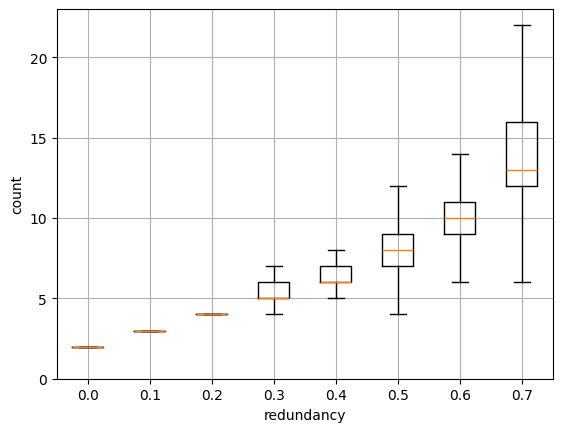

In [18]:
# Create box plots for frequency of cached ngrams at different redundancy levels.

frequencies = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_frequencies = []
    for experiment in relevant_experiments:
        relevant_frequencies.extend(experiment["fill_cache"]["ngram_frequencies"])


    frequencies.append(relevant_frequencies)

fig, ax = plt.subplots()

ax.boxplot(frequencies, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("count")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the frequency of each cached ngram in the population:")

plt.grid()

plt.savefig(f"{target_dir}/frequency_over_redundancy.png")
plt.show()

Distribution of retrieved ngram lengths for redundancy 0.0:
	Total hit count: 1836
	Total computations saved: 2352 of 4995000 (0.05 %)
	Average cache slots used: 287 of 10000 (2.87 %)
	Share of len=2 hits: 99.46 %
	Mean hit sequence length: 2.281045751633987
	Median hit sequence length: 2.0


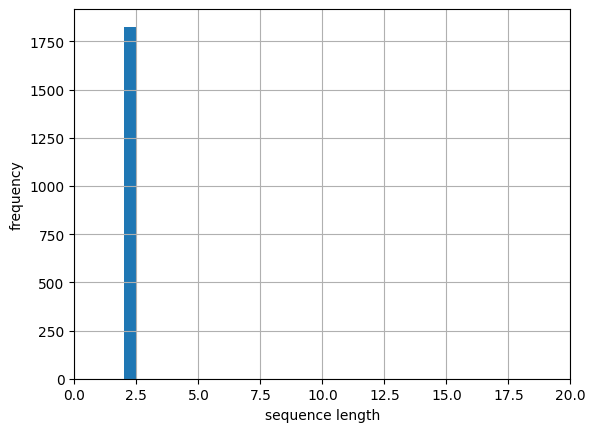

Distribution of retrieved ngram lengths for redundancy 0.1:
	Total hit count: 80119
	Total computations saved: 82062 of 4995000 (1.64 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.0242514260038194
	Median hit sequence length: 2


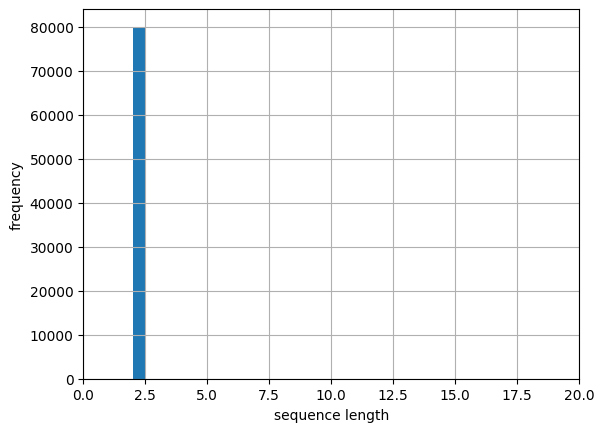

Distribution of retrieved ngram lengths for redundancy 0.2:
	Total hit count: 104876
	Total computations saved: 107318 of 4995000 (2.15 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.023284640909264
	Median hit sequence length: 2.0


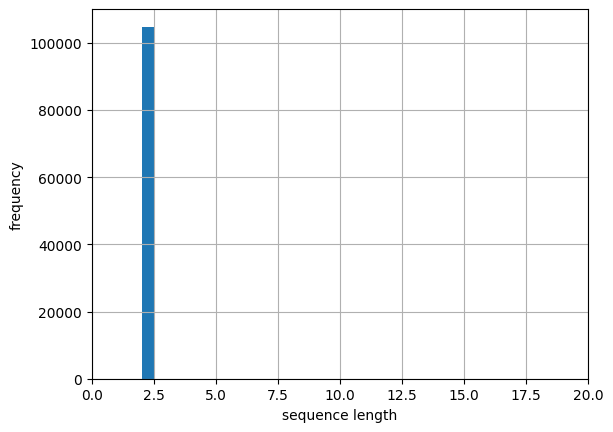

Distribution of retrieved ngram lengths for redundancy 0.3:
	Total hit count: 131199
	Total computations saved: 134246 of 4995000 (2.69 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.0232242623800487
	Median hit sequence length: 2


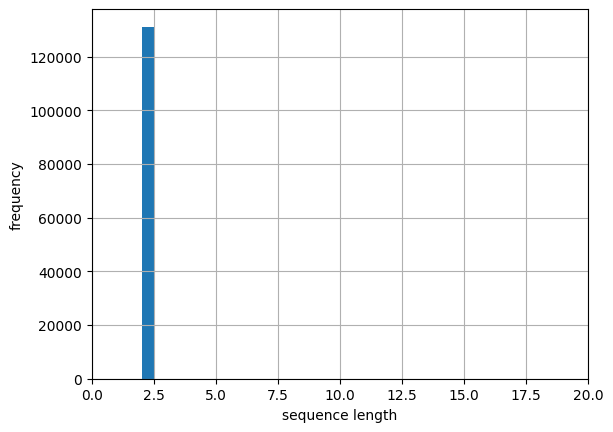

Distribution of retrieved ngram lengths for redundancy 0.4:
	Total hit count: 162157
	Total computations saved: 164955 of 4995000 (3.3 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.9 %
	Mean hit sequence length: 2.0172548826137633
	Median hit sequence length: 2


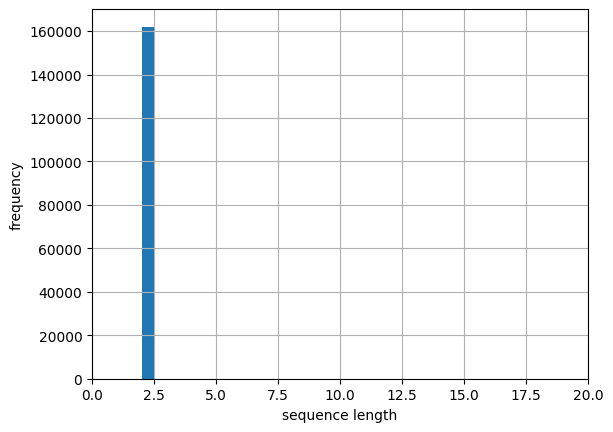

Distribution of retrieved ngram lengths for redundancy 0.5:
	Total hit count: 209267
	Total computations saved: 212612 of 4995000 (4.26 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.88 %
	Mean hit sequence length: 2.0159843644721813
	Median hit sequence length: 2


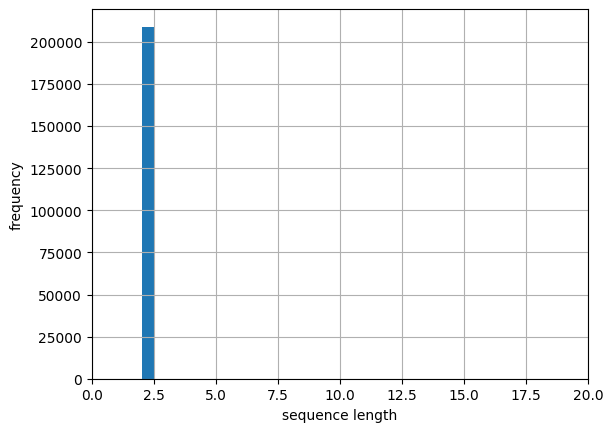

Distribution of retrieved ngram lengths for redundancy 0.6:
	Total hit count: 274431
	Total computations saved: 279401 of 4995000 (5.59 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.81 %
	Mean hit sequence length: 2.018110198920676
	Median hit sequence length: 2


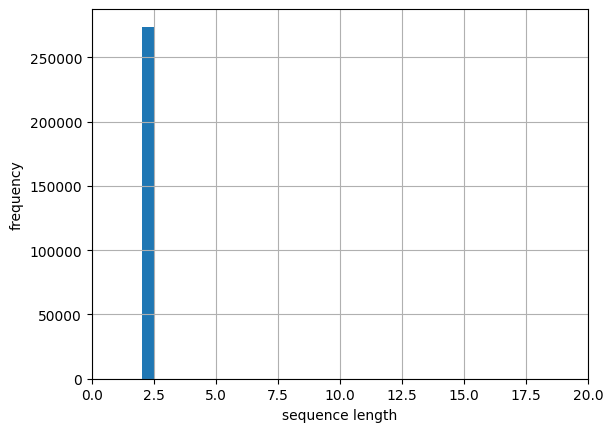

Distribution of retrieved ngram lengths for redundancy 0.7:
	Total hit count: 390835
	Total computations saved: 398147 of 4995000 (7.97 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.72 %
	Mean hit sequence length: 2.018708662223189
	Median hit sequence length: 2


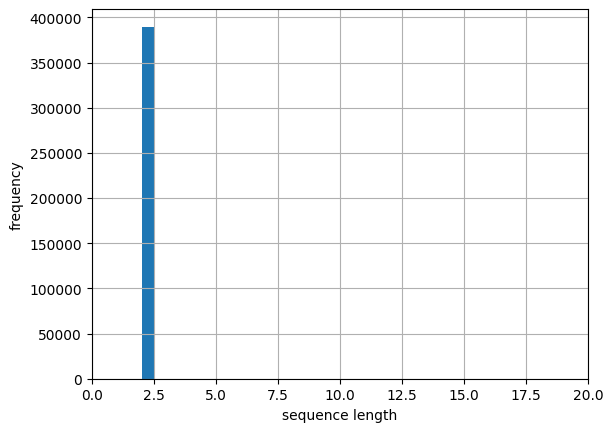

In [19]:
for redundancy in redundancies:
    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    hit_lengths = []
    for experiment in relevant_experiments:
        hit_lengths.extend(
            experiment["simulate_using_cache"]["hit_ngram_lenghts"])

    fig, ax = plt.subplots()

    upper_limit = 20
    bin_count = 40

    ax.hist(hit_lengths, bins=[upper_limit /
            bin_count * i for i in range(bin_count)])
    ax.set_xlabel("sequence length")
    ax.set_ylabel("frequency")
    ax.set_xlim([0, upper_limit])

    printb(
        f"Distribution of retrieved ngram lengths for redundancy {redundancy}:")
    print(f"\tTotal hit count: {len(hit_lengths)}")

    total_computations = len(relevant_experiments) * relevant_experiments[0]["params"]["circuit_count"] * (
        relevant_experiments[0]["params"]["gate_count"] - 1)
    total_gain = sum([
        (hit_length - 1) for hit_length in hit_lengths
    ])
    print(
        f"\tTotal computations saved: {total_gain} of {total_computations} ({round(100 * total_gain / total_computations, 2)} %)")

    cache_slots_used = int(sum([
        len(experiment["fill_cache"]["ngram_lengths"]) for experiment in relevant_experiments
    ]) / len(relevant_experiments))
    cache_size = relevant_experiments[0]["params"]["cache_size"]

    print(
        f"\tAverage cache slots used: {cache_slots_used} of {cache_size} ({round(100 * cache_slots_used / cache_size, 2)} %)")

    len2_hits_count = len(
        [hit_length for hit_length in hit_lengths if hit_length == 2])
    print(
        f"\tShare of len=2 hits: {round(100 * len2_hits_count / len(hit_lengths), 2)} %")
    print(f"\tMean hit sequence length: {mean(hit_lengths)}")
    print(f"\tMedian hit sequence length: {median(hit_lengths)}")

    plt.grid()
    plt.show()

In [20]:
gains = []
hits = []
len2_shares = []

for redundancy in redundancies:
    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    hit_lengths = []
    for experiment in relevant_experiments:
        hit_lengths.extend(
            experiment["simulate_using_cache"]["hit_ngram_lenghts"])

    total_hits = len(hit_lengths)
    hits.append(total_hits)

    total_computations = len(relevant_experiments) * relevant_experiments[0]["params"]["circuit_count"] * (
        relevant_experiments[0]["params"]["gate_count"] - 1)
    total_gain = sum([
        (hit_length - 1) for hit_length in hit_lengths
    ])
    gains.append(total_gain)

    len2_hits_count = len(
        [hit_length for hit_length in hit_lengths if hit_length == 2])
    len2_share = round(100 * len2_hits_count / len(hit_lengths), 2)
    len2_shares.append(len2_share)


Total matrix multiplications saved:


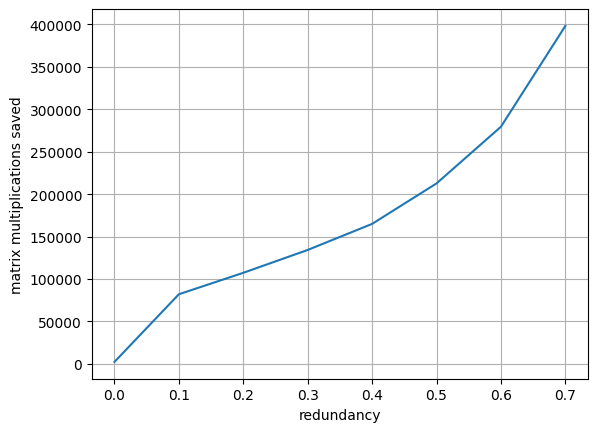

In [21]:
printb("Total matrix multiplications saved:")
ax = plt.subplot()
ax.plot(redundancies, gains)
ax.set_xlabel("redundancy")
ax.set_ylabel("matrix multiplications saved")

plt.grid()
plt.show()

Total hit count:


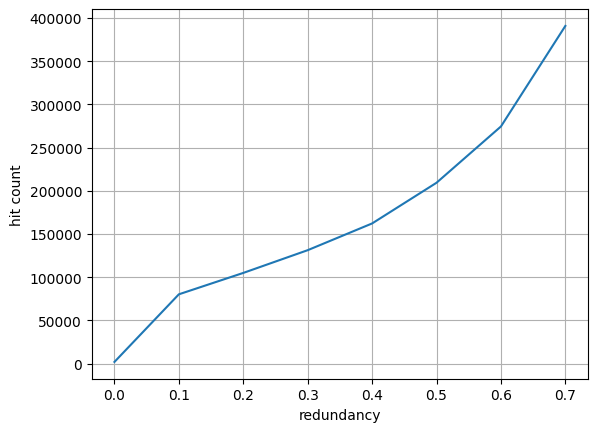

In [22]:
printb("Total hit count:")
ax = plt.subplot()
ax.plot(redundancies, hits)
ax.set_xlabel("redundancy")
ax.set_ylabel("hit count")

plt.grid()
plt.show()

Share of len2 ngrams:


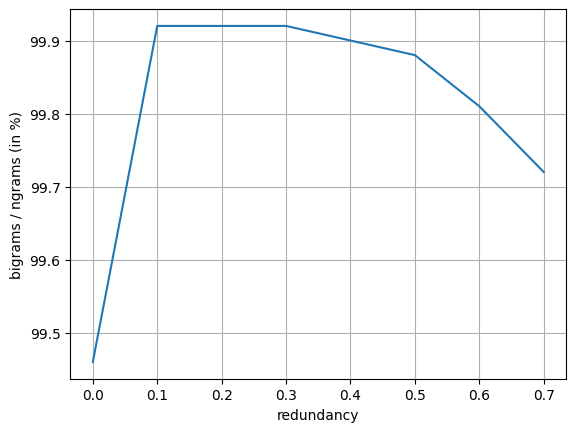

In [23]:
printb("Share of len2 ngrams:")
ax = plt.subplot()
ax.plot(redundancies, len2_shares)
ax.set_xlabel("redundancy")
ax.set_ylabel("bigrams / ngrams (in %)")

plt.grid()
plt.show()

## RQ2.1: How does the amount of qubits in the population influence simulation speed?

In [24]:
# Filter out and format experiment results with the varying_qubits tag

vq_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_qubits"]
print(f"Total amount of varying_qubits experiments: {len(vq_experiments)}")

Total amount of varying_qubits experiments: 50


In [25]:
qubit_nums = [experiment["params"]["qubit_num"] for experiment in vq_experiments]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

print("Qubit counts:", qubit_nums)

Qubit counts: [5, 6, 7, 8, 9]


Total simulation time, averaged across seeds:


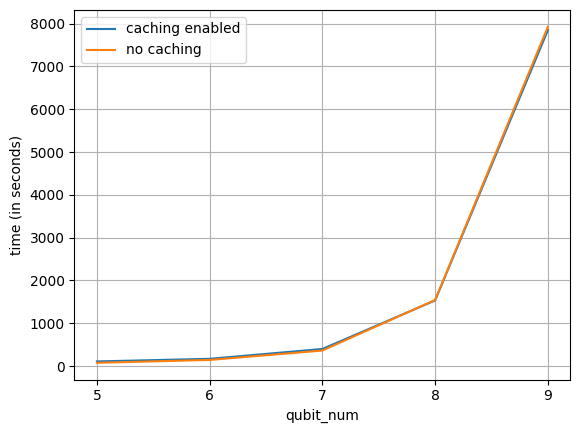

In [35]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for qubit_num in qubit_nums:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(qubit_nums, durations_with_cache, label="caching enabled")
ax.plot(qubit_nums, durations_no_cache, label="no caching")
ax.set_xlabel("qubit_num")
ax.set_ylabel("time (in seconds)")
# ax.set_ylim(8000, 8500)

ax.set_xticks(qubit_nums)

printb("Total simulation time, averaged across seeds:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_qubit_num.png")
plt.show()


Ratio of total simulation time no-caching over caching, averaged across seeds:


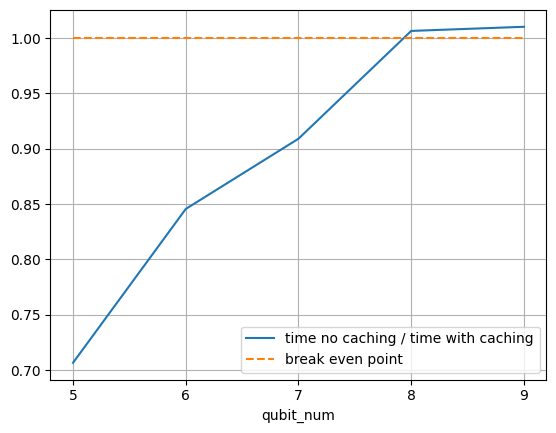

In [34]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

ratios = []

for qubit_num in qubit_nums:

    durations_no_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]

    durations_with_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]

    ratio = mean(durations_no_cache) / mean(durations_with_cache)
    ratios.append(ratio)

ax = plt.subplot()
ax.plot(qubit_nums, ratios, label="time no caching / time with caching")
ax.plot(qubit_nums, [1 for _ in qubit_nums], label="break even point", linestyle="dashed")
ax.set_xlabel("qubit_num")

ax.set_xticks(qubit_nums)

printb("Ratio of total simulation time no-caching over caching, averaged across seeds:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_ratio_over_qubit_num.png")
plt.show()


Components of total simulation time, averaged across seeds:


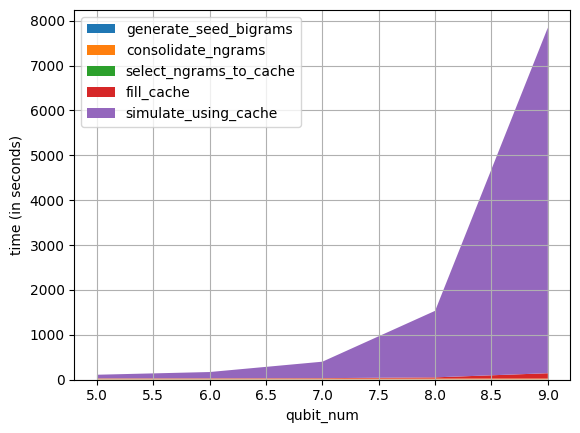

In [ ]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for qubit_num in qubit_nums:

    relevant_experiments = [
        experiment
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]

    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )

x = qubit_nums
y = np.vstack(
    [
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("qubit_num")
ax.set_ylabel("time (in seconds)")

printb("Components of total simulation time, averaged across seeds:")

plt.legend(
    [
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

plt.savefig(f"{target_dir}/time_over_qubit_num_stacked.png")
plt.show()

## RQ2.2: How does the amount of gates per circuit influence simulation speed?

In [ ]:
# Filter out and format experiment results with the varying_gates tag

vg_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_gates"]
print(f"Total amount of varying_gates experiments: {len(vg_experiments)}")

Total amount of varying_gates experiments: 50


In [ ]:
gate_counts = [experiment["params"]["gate_count"] for experiment in vg_experiments]
gate_counts = list(set(gate_counts))
gate_counts.sort()

print("Gate counts:", gate_counts)

Gate counts: [400, 800, 1200, 1600, 2000]


Total simulation time, averaged across seeds:


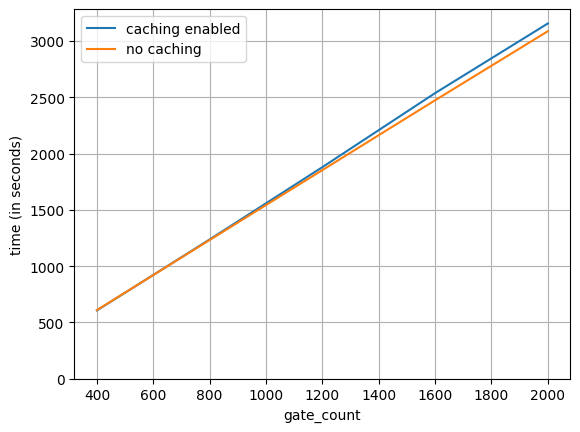

In [ ]:
# Create a line chart with simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for gate_count in gate_counts:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(gate_counts, durations_with_cache, label="caching enabled")
ax.plot(gate_counts, durations_no_cache, label="no caching")
ax.set_xlabel("gate_count")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend()
plt.grid()
plt.show()


Net simulation time, averaged across seeds:


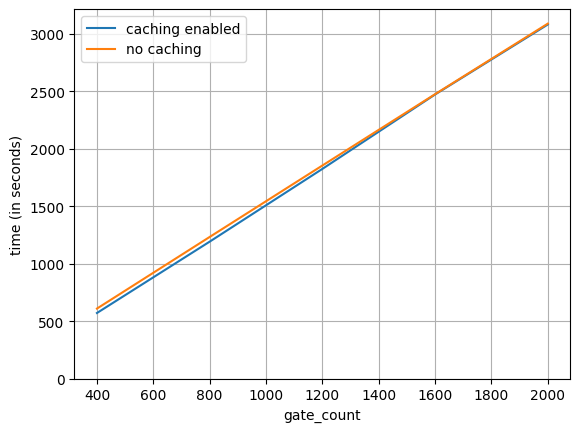

In [ ]:
# Create a line chart with net simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for gate_count in gate_counts:

    sel_durations_no_cache = [
        experiment["simulate_without_cache"]["duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(gate_counts, durations_with_cache, label="caching enabled")
ax.plot(gate_counts, durations_no_cache, label="no caching")
ax.set_xlabel("gate_count")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Net simulation time, averaged across seeds:")
plt.legend()
plt.grid()
plt.show()
